# Comprehensive Guide to Helpfulness Scorer Model Usage and Evaluation

This notebook demonstrates how to use a trained helpfulness scorer model to evaluate response quality, compare responses, and generate visualizations of the results. It builds on the trained model from the previous notebook and extends it with practical utilities for real-world application.

## What This Notebook Does

1. **Model Loading and Setup**:
   - Loads the pretrained helpfulness scorer model
   - Sets up the necessary tokenizer for text processing
   - Defines helper functions for scoring and comparing responses

2. **Scoring Utilities**:
   - Implements functions to score individual responses on a 0-10 scale
   - Creates comparative evaluation tools to determine preference between response pairs
   - Provides batch processing capability for efficient evaluation of multiple examples

3. **Interactive Testing**:
   - Demonstrates the model on example context-response pairs
   - Includes an interactive interface for user-provided inputs
   - Shows how to interpret model outputs and preference strengths

4. **Visualization and Analysis**:
   - Implements histogram visualization to understand score distributions
   - Generates sample scores across different quality levels to show model behavior
   - Helps identify the model's scoring patterns and tendencies

5. **GPT-2 Integration**:
   - Sets up GPT-2 for generating AI responses
   - Connects generation with evaluation for end-to-end demonstration
   - Shows how the model can be used to evaluate AI-generated content

## Key Components

- **Score Response Function**: Evaluates single responses on a 0-10 scale
- **Compare Responses Function**: Determines preference between two responses with strength indicators
- **Batch Processing Tools**: Efficiently handles multiple evaluations
- **Visualization Functions**: Creates histograms and other visual analytics
- **Interactive Testing Interface**: Allows for experimentation with custom inputs
- **GPT-2 Response Generator**: Creates AI responses for evaluation

## Usage Patterns

This notebook demonstrates several ways to use the helpfulness scorer:

1. **Quality Assessment**: Evaluate how helpful a single response is to a given question
2. **Comparative Analysis**: Determine which of two responses better answers a question
3. **Batch Evaluation**: Process multiple examples for larger-scale analysis
4. **Distribution Visualization**: Understand scoring patterns and model behavior
5. **AI Response Evaluation**: Generate and evaluate AI-produced responses

The utilities provided in this notebook can be integrated into larger systems for automated response quality assessment, chatbot evaluation, or as components in reinforcement learning from human feedback (RLHF) pipelines.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", token="HIDDEN")  # Replace with your actual token

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
class HelpfulnessScorer(nn.Module):
   """
   Neural network model for evaluating response helpfulness in context.

   This model encodes both a context (question) and response using a transformer model,
   then calculates a helpfulness score indicating how well the response answers the question.
   It uses mean pooling for better text representation and a multi-layer scoring head with
   regularization to prevent overfitting.

   Architecturally, this is similar to reward models used in RLHF (Reinforcement Learning
   from Human Feedback) pipelines but focused specifically on response helpfulness.

   Args:
       model_name (str): Name of the pretrained transformer model to use as the encoder.
                         Default is "distilbert-base-uncased".
   """
   def __init__(self, model_name="distilbert-base-uncased"):
       super(HelpfulnessScorer, self).__init__()
       # Initialize the transformer encoder from pretrained model
       self.encoder = AutoModel.from_pretrained(model_name)
       hidden_size = self.encoder.config.hidden_size

       # Projection layers to reduce dimensionality of encoded representations
       self.context_proj = nn.Linear(hidden_size, 192)
       self.response_proj = nn.Linear(hidden_size, 192)

       # Scoring network with dropout for regularization
       self.score_head = nn.Sequential(
           nn.Linear(384, 192),  # First fully connected layer
           nn.ReLU(),            # Activation function
           nn.Dropout(0.3),      # Dropout to prevent overfitting
           nn.Linear(192, 64),   # Second fully connected layer
           nn.ReLU(),            # Activation function
           nn.Dropout(0.3),      # Additional dropout
           nn.Linear(64, 1)      # Output layer for single helpfulness score
       )

   def mean_pooling(self, token_embeddings, attention_mask):
       """
       Apply mean pooling over token embeddings to get a sentence representation.

       This method averages all token embeddings in the sequence, weighted by the
       attention mask (so padding tokens don't contribute).

       Args:
           token_embeddings: Embeddings of all tokens from transformer [batch_size, seq_len, hidden_size]
           attention_mask: Mask indicating real tokens vs padding [batch_size, seq_len]

       Returns:
           Pooled representations [batch_size, hidden_size]
       """
       input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
       sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
       sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)  # Prevent division by zero
       return sum_embeddings / sum_mask

   def encode_text(self, input_ids, attention_mask):
       """
       Encode text using transformer and apply pooling.

       Args:
           input_ids: Token IDs [batch_size, seq_len]
           attention_mask: Attention mask [batch_size, seq_len]

       Returns:
           Pooled text representation [batch_size, hidden_size]
       """
       outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
       # Apply mean pooling to get better sentence-level representation
       return self.mean_pooling(outputs.last_hidden_state, attention_mask)

   def forward(self, context_input_ids, context_attention_mask, response_input_ids, response_attention_mask):
       """
       Forward pass to calculate helpfulness score.

       Args:
           context_input_ids: Token IDs for the context/question [batch_size, seq_len]
           context_attention_mask: Attention mask for context [batch_size, seq_len]
           response_input_ids: Token IDs for the response [batch_size, seq_len]
           response_attention_mask: Attention mask for response [batch_size, seq_len]

       Returns:
           Scalar helpfulness score [batch_size]
       """
       # Encode context and response
       context_vec = self.encode_text(context_input_ids, context_attention_mask)
       response_vec = self.encode_text(response_input_ids, response_attention_mask)

       # Project to lower dimension
       context_vec = self.context_proj(context_vec)
       response_vec = self.response_proj(response_vec)

       # Concatenate context and response representations
       combined = torch.cat([context_vec, response_vec], dim=1)

       # Calculate helpfulness score
       score = self.score_head(combined)
       return score.squeeze()

In [ ]:
# Load the model

print("Downloading model files...")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_auth_token=False)
base_model = AutoModel.from_pretrained("distilbert-base-uncased", use_auth_token=False)
print("Model files downloaded successfully!")

def load_helpfulness_model(model_path):
    model = HelpfulnessScorer()
    state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)

    if 'model_state_dict' in state_dict:
        model.load_state_dict(state_dict['model_state_dict'])
    else:
        model.load_state_dict(state_dict)

    model.eval()
    return model

model_path = "/content/drive/MyDrive/COMP560/Final/helpfulness_scorer_final_model.pt"  # Update with your model path
model = load_helpfulness_model(model_path)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:862: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Model files downloaded successfully!


In [ ]:
# Response Scoring and Comparison Functions
#
# This cell provides utility functions for evaluating and comparing response
# helpfulness, along with test examples to demonstrate their functionality.

# Helper function to score a response
def score_response(context, response, model=model, tokenizer=tokenizer):
   """
   Calculate the helpfulness score for a single response to a given context.

   Args:
       context: The question or context text
       response: The response to evaluate
       model: The helpfulness scorer model (default: loaded model)
       tokenizer: Tokenizer for text processing (default: loaded tokenizer)

   Returns:
       float: Helpfulness score on a 0-10 scale
   """
   # Tokenize inputs with appropriate maximum lengths
   context_tokens = tokenizer(context, truncation=True, padding="max_length",
                             max_length=512, return_tensors="pt")
   response_tokens = tokenizer(response, truncation=True, padding="max_length",
                              max_length=384, return_tensors="pt")

   # Get model's raw score without gradient computation
   with torch.no_grad():
       raw_score = model(
           context_tokens['input_ids'],
           context_tokens['attention_mask'],
           response_tokens['input_ids'],
           response_tokens['attention_mask']
       ).item()

   # Convert to 0-10 scale using sigmoid transformation
   scaled_score = (torch.sigmoid(torch.tensor(raw_score)) * 10).item()
   return scaled_score

# Helper function to compare two responses
def compare_responses(context, response1, response2, model=model, tokenizer=tokenizer):
   """
   Compare two responses to the same context and determine which is more helpful.

   Args:
       context: The question or context text
       response1: The first response to evaluate
       response2: The second response to evaluate
       model: The helpfulness scorer model (default: loaded model)
       tokenizer: Tokenizer for text processing (default: loaded tokenizer)

   Returns:
       dict: Comparison results including scores, preference strength, and preferred response
   """
   # Get individual scores for each response
   score1 = score_response(context, response1, model, tokenizer)
   score2 = score_response(context, response2, model, tokenizer)

   # Calculate preference strength on a -3 to 3 scale
   diff = score2 - score1
   normalized_diff = min(max(diff * 0.3, -3), 3)  # Scale to [-3, 3]

   # Return comprehensive results dictionary
   return {
       'response1_score': score1,
       'response2_score': score2,
       'preference_strength': normalized_diff,
       'preferred': 'response2' if normalized_diff > 0 else 'response1',
       'direction_correct': normalized_diff > 0  # Assumes response2 should be better
   }

# Test examples with contrasting response quality
test_examples = [
   {
       "context": "Can you explain how photosynthesis works?",
       "good_response": "Photosynthesis is the process by which plants convert light energy into chemical energy. It takes place in the chloroplasts, specifically using chlorophyll in the thylakoids. The process involves capturing light energy to convert carbon dioxide and water into glucose and oxygen.",
       "bad_response": "It's when plants make food."
   },
   {
       "context": "What's the best way to learn Python?",
       "good_response": "To learn Python effectively, start with the basics like syntax and data types, then practice with small projects. Online resources like Codecademy, freeCodeCamp, and Python's official documentation are excellent. Join communities like Stack Overflow or Reddit's r/learnpython. Most importantly, build projects that interest you to stay motivated.",
       "bad_response": "Just Google it."
   }
]

# Run tests and display results
print("Testing Helpfulness Scorer Model:")
print("-" * 60)

Testing Helpfulness Scorer Model:
------------------------------------------------------------


In [ ]:

for example in test_examples:
    result = compare_responses(
        example["context"],
        example["bad_response"],
        example["good_response"]
    )

    print(f"Context: {example['context']}")
    print(f"Good response score: {result['response2_score']:.2f}/10")
    print(f"Basic response score: {result['response1_score']:.2f}/10")
    print(f"Preference strength: {result['preference_strength']:.2f} [-3 to 3 scale]")
    print(f"Preferred response: {result['preferred']}")
    print("-" * 60)

# Interactive testing interface
def interactive_test():
    context = input("Enter a question or context: ")
    resp1 = input("Enter first response: ")
    resp2 = input("Enter second response: ")

    result = compare_responses(context, resp1, resp2)

    print(f"\nResults:")
    print(f"Response 1 score: {result['response1_score']:.2f}/10")
    print(f"Response 2 score: {result['response2_score']:.2f}/10")
    print(f"Preferred response: {result['preferred']}")
    print(f"Preference strength: {result['preference_strength']:.2f} [-3 to 3 scale]")

    return result

Context: Can you explain how photosynthesis works?
Good response score: 5.15/10
Basic response score: 4.72/10
Preference strength: 0.13 [-3 to 3 scale]
Preferred response: response2
------------------------------------------------------------
Context: What's the best way to learn Python?
Good response score: 5.45/10
Basic response score: 5.40/10
Preference strength: 0.02 [-3 to 3 scale]
Preferred response: response2
------------------------------------------------------------


In [ ]:
interactive_test()

KeyboardInterrupt: Interrupted by user

Scoring responses:   0%|          | 0/2 [00:00<?, ?it/s]

Context: What is AI?
Score: 5.17/10

Context: How does a car engine work?
Score: 5.01/10



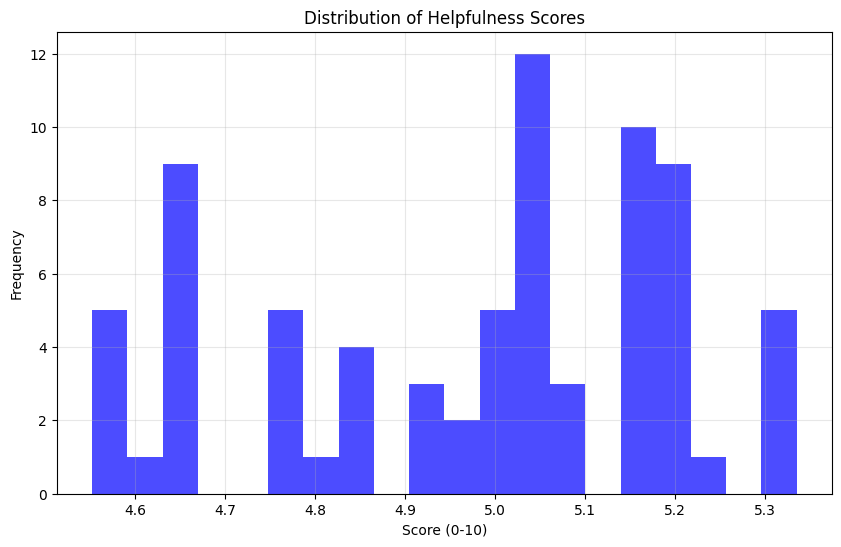

In [ ]:
# Batch Processing and Score Visualization Functions
#
# This cell implements utilities for batch processing multiple examples
# and visualizing the distribution of helpfulness scores.

# Batch scoring function for processing multiple examples efficiently
def batch_score_responses(data_list, model=model, tokenizer=tokenizer):
   """
   Score a batch of examples for efficiency.

   This function processes multiple context-response pairs and calculates
   helpfulness scores for each, returning comprehensive results.

   Args:
       data_list: List of dictionaries, each with 'context' and 'response' keys
       model: The helpfulness scorer model (default: loaded model)
       tokenizer: Tokenizer for text processing (default: loaded tokenizer)

   Returns:
       list: List of dictionaries with original inputs and calculated scores
   """
   results = []

   for item in tqdm(data_list, desc="Scoring responses"):
       score = score_response(item['context'], item['response'], model, tokenizer)
       results.append({
           'context': item['context'],
           'response': item['response'],
           'score': score
       })

   return results

# Example of using batch scoring with simple test data
test_data = [
   {"context": "What is AI?", "response": "AI is artificial intelligence"},
   {"context": "How does a car engine work?", "response": "It burns fuel to create motion"}
]
batch_results = batch_score_responses(test_data)
for result in batch_results:
   print(f"Context: {result['context']}")
   print(f"Score: {result['score']:.2f}/10\n")

# Function to visualize the distribution of helpfulness scores
def visualize_scores(scores):
   """
   Create a histogram visualization of helpfulness score distribution.

   Args:
       scores: List of numerical scores to visualize
   """
   plt.figure(figsize=(10, 6))
   plt.hist(scores, bins=20, alpha=0.7, color='blue')
   plt.title('Distribution of Helpfulness Scores')
   plt.xlabel('Score (0-10)')
   plt.ylabel('Frequency')
   plt.grid(True, alpha=0.3)
   plt.show()

# Function to generate and visualize sample scores across a range of quality levels
def generate_sample_scores():
   """
   Generate sample scores across various contexts and response quality levels.

   This function creates combinations of contexts with good, medium, and poor
   quality responses, scores them all, and visualizes the distribution.

   Returns:
       list: All calculated helpfulness scores
   """
   example_contexts = [
       "What is artificial intelligence?",
       "How do I bake a chocolate cake?",
       "Can you explain quantum physics?",
       "What's the best way to learn a new language?",
       "How does the internet work?"
   ]

   example_responses = [
       # Good responses - detailed, informative, and complete
       "Artificial Intelligence (AI) refers to systems designed to mimic human intelligence and perform tasks that typically require human cognitive abilities such as learning, problem-solving, perception, and decision-making.",
       "To bake a chocolate cake, you'll need: 2 cups flour, 1 cup sugar, 1/2 cup cocoa powder, 1.5 tsp baking powder, 1 tsp salt, 2 eggs, 1 cup milk, 1/2 cup oil, and 2 tsp vanilla extract. Mix dry ingredients, then add wet ingredients and stir until combined. Bake at 350°F for 30-35 minutes.",
       "Quantum physics is a branch of physics that deals with the behavior of matter and energy at the smallest scales. It describes how particles like electrons and photons behave in ways that defy classical physics, including wave-particle duality, superposition, and quantum entanglement.",
       "The best way to learn a new language is to immerse yourself in it. Start with the basics, practice daily, use apps like Duolingo, watch shows in that language, find native speakers to practice with, and don't be afraid to make mistakes.",
       "The internet works through a global network of interconnected computers that communicate using standardized protocols. When you access a website, your device sends a request through your ISP to servers that host the website, which then send the data back to your device.",

       # Medium responses - basic information but lacking detail
       "AI is computer systems that can perform tasks that normally require human intelligence.",
       "Mix flour, sugar, cocoa powder, eggs, milk, and oil. Bake until done.",
       "Quantum physics studies very small particles that behave in strange ways compared to everyday objects.",
       "Practice daily, use language apps, and try to talk with native speakers.",
       "The internet is a network of computers that share information using special protocols.",

       # Poor responses - minimal, unhelpful information
       "It's smart computers.",
       "Just follow a recipe.",
       "It's complicated physics.",
       "Download an app.",
       "It just works."
   ]

   # Score all combinations of contexts and responses
   scores = []
   for context in example_contexts:
       for response in example_responses:
           score = score_response(context, response)
           scores.append(score)

   # Visualize the distribution of scores
   visualize_scores(scores)
   return scores

# Generate sample scores and visualize their distribution
sample_scores = generate_sample_scores()

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load GPT-2
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2", token="HIDDEN")
gpt2_model = AutoModelForCausalLM.from_pretrained("gpt2", token="HIDDEN")

def generate_gpt2_response(prompt, max_length=100):
    inputs = gpt2_tokenizer.encode(prompt, return_tensors="pt")
    outputs = gpt2_model.generate(inputs, max_length=max_length, do_sample=True, temperature=0.7)
    response = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response[len(prompt):].strip()


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
context = "What are the benefits and drawbacks of remote work?"
gpt2_response = generate_gpt2_response(context)
print("GPT-2 Response:", gpt2_response)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


GPT-2 Response: For those with a spare time, you can work remotely with people you don't know, your family, or some other friend. You can join a group and interact with other members, or even create projects and work on your own.

But as with any skill, there are times when you must make the decision to do something that you don't want to do. It's not hard to imagine a world where you can work for
